File name: Investigation_3.ipynb               
Author: Florian Imorde                      
Latest Update: 26.07.2019         

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM, LeakyReLU
from keras.models import load_model

Using TensorFlow backend.


# 0) Task

**Questions:**

Each business in the YELP dataset is rated by the YELP community by reviews. By understanding the reviews and there positive/negative judgment, business can improve and optimize better to the wishes and needs of their customers.

**Approach:**

Step 1: Preprocessing the reviews and relabel the 'star' rating into positive and negative reviews. <br>
Step 2: Build up a Deep Learning Model for the sentiment analysis <br>

# 1) Preprocessing

## 1.1) Load the data

In [2]:
path_dataset_review = '../data/yelp_dataset/review.json'

In [3]:
# The 6.685.899 reviews of the dataset are to much for computation on a laptop. 
# Hence load just a view reviews manually.

# Define the number of reviews to load from the file
nr_reviews = 500000

# Load the reviews from the reviews dataset
file = open(path_dataset_review, encoding="utf8") 
all_data = list()
for i, line in enumerate(file):
    if i%(nr_reviews/10)==0:
        print(str(i*100/nr_reviews)+'% loaded' )
    if i == nr_reviews:
        break    
    data = json.loads(line)
    # extract only the review and the star rating form the line
    text = data['text']
    stars = data['stars']
    all_data.append([stars, text])
file.close()

# Create the DataFrame
df = pd.DataFrame(all_data, columns=['stars','text'])

0.0% loaded
10.0% loaded
20.0% loaded
30.0% loaded
40.0% loaded
50.0% loaded
60.0% loaded
70.0% loaded
80.0% loaded
90.0% loaded
100.0% loaded


In [4]:
df.head()

,stars,text
0,1.0,Total bill for this horrible service? Over $8G...
1,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,5.0,I have to say that this office really has it t...
3,5.0,Went in for a lunch. Steak sandwich was delici...
4,1.0,Today was my second out of three sessions I ha...


## 1.2) EDA

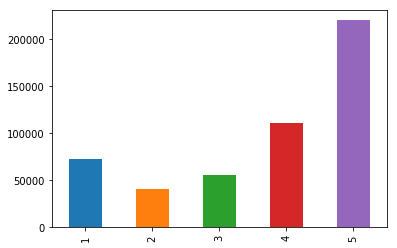

In [5]:
# Distribution of the star ratings
star_count = df['stars'].value_counts()
star_count.reindex([1, 2, 3, 4, 5]).plot.bar()

In [6]:
df['text'][0]

'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.'

In [7]:
df['text'][1]

"I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.  Travis has freakishly strong fingers (in a good way) and use the perfect amount of pressure.  That was superb!  Then starts the glorious blowout... where not one, not two, but THREE people were involved in doing the best round-brush action my hair has ever seen.  The team of stylists clearly gets along extremely well, as it's evident from the way they talk to and help one another that it's really genuine and not some corporate requirement.  It was so mu

### 1.2.1) Increase the review quality

In [8]:
# Lowercase all words in the reviews
df['processed_text'] = df['text'].str.lower()

In [9]:
# Tokenize the reviews
# Simultaneously the punctation is removed
tokenize = RegexpTokenizer('\w+')
df['processed_text'] = df['processed_text'].apply(lambda review : tokenize.tokenize(review))

In [10]:
# Remove stopwords for the reviews
stoplist = stopwords.words('english')
df['processed_text'] = df['processed_text'].apply(lambda review: ' '.join([word for word in review if word not in stoplist]))

In [11]:
df['processed_text'].head()

0    total bill horrible service 8gs crooks actuall...
1    adore travis hard rock new kelly cardenas salo...
2    say office really together organized friendly ...
3    went lunch steak sandwich delicious caesar sal...
4    today second three sessions paid although firs...
Name: processed_text, dtype: object

In [12]:
# Stemming the words in the reviews
stemmer = SnowballStemmer('english')
df['processed_text'] = df['processed_text'].apply(lambda review: ' '.join([stemmer.stem(word) for word in review.split()]))

In [13]:
print('The max length of words in a review befor the preprocessing:', max(df['text'].agg(len)))
print('The max length of words in a review befor the preprocessing:', max(df['processed_text'].agg(len)))

The max length of words in a review befor the preprocessing: 5000
The max length of words in a review befor the preprocessing: 3789


## 1.3) Analyse the reviews

In [14]:
# 10 most common words
counter_words = Counter(" ".join(df['processed_text']).split())
print('Most common words:')
counter_words.most_common(10)

Most common words:


[('place', 272724),
 ('food', 264131),
 ('good', 248978),
 ('time', 219238),
 ('great', 216520),
 ('get', 199139),
 ('like', 196982),
 ('go', 193532),
 ('servic', 188343),
 ('order', 173632)]

In [15]:
# 10 least common words
print('Least common words:')
counter_words.most_common()[-10:]

Least common words:


[('überflüssig', 1),
 ('geschirr', 1),
 ('abzuräumen', 1),
 ('nahrungsmittelbedarf', 1),
 ('gerechtfertigt', 1),
 ('mischkalkul', 1),
 ('eindeutig', 1),
 ('stagea', 1),
 ('strave', 1),
 ('horrinl', 1)]

In [16]:
print('The max length of words in a review befor the preprocessing:', max(df['text'].agg(len)))
print('The max length of words in a review after the preprocessing:', max(df['processed_text'].agg(len)))

The max length of words in a review befor the preprocessing: 5000
The max length of words in a review after the preprocessing: 3789


In [17]:
# Total different words
print('Number of different words in the review:', len(counter_words.most_common()))

Number of different words in the review: 125703


In [18]:
# The last 100000 words are appearing very rearly
counter_words.most_common()[-100000]

('lifespan', 10)

In [19]:
counter_words.most_common()[25000]

('lsd', 10)

**Conclusion:** <br>
Only use the 25.000 most common words for this investigation

In [20]:
VOCAB_LEN = 25000

## 1.4) Maximal length of the reviews

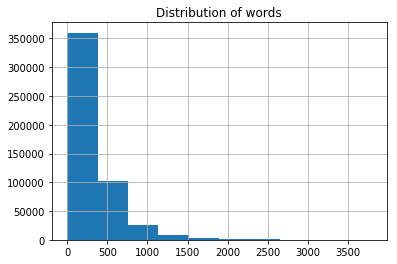

count    500000.000000
mean        323.477052
std         297.801631
min           0.000000
25%         132.000000
50%         231.000000
75%         409.000000
max        3789.000000
dtype: float64

In [21]:
# Distribution of the number of words in a review
reviews_len = [len(x) for x in df['processed_text']]
pd.Series(reviews_len).hist()
plt.title('Distribution of words')
plt.show()
pd.Series(reviews_len).describe()

The histogram is showing, that the some reviews are written with 1000 and more words. For simplicity and reduction of complexity drop all reviews lower than the 10% quantile and greater than the 75% quantile.

In [22]:
lower_bountary = np.quantile(reviews_len, 0.10)
upper_bountary = np.quantile(reviews_len, 0.75)
index = np.argwhere((reviews_len > lower_bountary) & (reviews_len < upper_bountary))

In [23]:
# Delete to short and to long reviews
df_reduce = df.loc[index.reshape(-1)]
df_reduce = df_reduce.reset_index(drop=True)
print('Shape of df:       ', df.shape)
print('Shape of df_reduce:', df_reduce.shape)

Shape of df:        (500000, 3)
Shape of df_reduce: (323876, 3)


## 1.5) Relabel the 'star' rating

In [24]:
# The value 1 indicates a positive review
# The value 0 indicates a negative review
df_reduce['stars_relabeled'] = [1 if x > 3 else 0 for x in df_reduce['stars']]

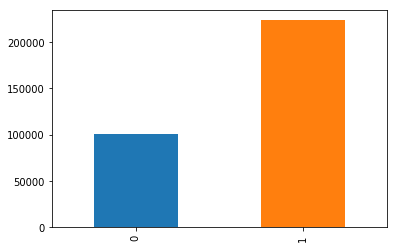

In [25]:
# Distribution of the relabeld star ratings
star_relabeld_count = df_reduce['stars_relabeled'].value_counts()
star_relabeld_count.reindex([0, 1]).plot.bar()

## 1.6) Balance the dataset

In [26]:
# Oversampling the negative reviews
df_stars_1 = df_reduce[df_reduce['stars_relabeled']==1]
df_stars_0 = df_reduce[df_reduce['stars_relabeled']==0].sample(star_relabeld_count[1], replace=True, random_state=42)
df_balanced = pd.concat([df_stars_0, df_stars_1], axis=0)
df_balanced = df_balanced.reset_index(drop=True)

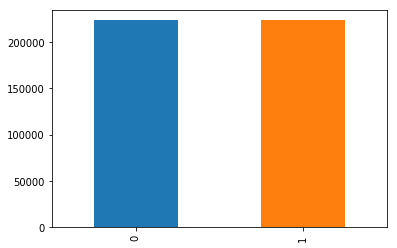

In [27]:
# Distribution of the relabeld star ratings
star_relabeld_balanced_count = df_balanced['stars_relabeled'].value_counts()
star_relabeld_balanced_count.reindex([0, 1]).plot.bar()

## 1.7) Padding and pruning the reviews 

For inputing the reviews in a neural network, all reviews have to be from equal length. Hence, pad to short reviews with 0 and prune to long reviews to the maximal length. At the same time the words are transformed to numbers.

In [28]:
SEQ_LEN = 100

In [29]:
tokenizer = Tokenizer(num_words=VOCAB_LEN)
tokenizer.fit_on_texts(df_balanced['processed_text'])

In [30]:
sequences = tokenizer.texts_to_sequences(df_balanced['processed_text'])
X = pad_sequences(sequences, maxlen=SEQ_LEN)
target = df_balanced['stars_relabeled']

In [31]:
X.shape

(446982, 100)

# 2) Train-, Validation-, Test-Set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X , target, test_size=0.7, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=42)

In [33]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:  ', X_val.shape)
print('Shape of X_test: ', X_test.shape)

Shape of X_train: (67047, 100)
Shape of X_val:   (67047, 100)
Shape of X_test:  (312888, 100)


# 3) Building the model

## 3.1) Neural Network (model 1)

Building up a Neural Network with an Embedding Layer and an LSTM Layer.

In [34]:
EMB_DIM = 100

In [35]:
model1 = Sequential()

model1.add(Embedding(VOCAB_LEN, EMB_DIM, input_length=SEQ_LEN))
model1.add(LSTM(units=EMB_DIM, dropout=0.4, recurrent_dropout=0.4))
model1.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,580,501
Trainable params: 2,580,501
Non-trainable params: 0
_________________________________________________________________


In [38]:
result_model1 = model1.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 67047 samples, validate on 67047 samples
Epoch 1/3
67047/67047 [==============================] - 328s 5ms/step - loss: 0.3402 - acc: 0.8553 - val_loss: 0.2767 - val_acc: 0.8859
Epoch 2/3
67047/67047 [==============================] - 342s 5ms/step - loss: 0.2463 - acc: 0.9008 - val_loss: 0.2709 - val_acc: 0.8878
Epoch 3/3
67047/67047 [==============================] - 349s 5ms/step - loss: 0.2088 - acc: 0.9163 - val_loss: 0.2812 - val_acc: 0.8867


In [47]:
score_train_m1, accu_train_m1 = model1.evaluate(X_train, y_train)
score_val_m1, accu_val_m1 = model1.evaluate(X_val, y_val)
score_test_m1, accu_test_m1 = model1.evaluate(X_test, y_test)
print('The accuracy of the first neural network:')
print('Test Set:      ', accu_train_m1)
print('Validation Set:', accu_val_m1)
print('Train Set:     ', accu_test_m1)

312888/312888 [==============================] - 262s 838us/step
The accuracy of the first neural network:
Test Set:       0.940206124062225
Validation Set: 0.8866914254197683
Train Set:      0.8872983303929841


In [40]:
# Save the model
filename = 'LSTM_model_1.h5'
model1.save('../Models/Investigation_3/'+filename)

# 4) Outlook

To improve the sentiment analysis, the following suggestions are made:
* Use pre-learned embedding (e.g. Glove)
* Experiment with different neural network designs
* ...